In [1]:
%matplotlib inline

## ACTIVIDAD 2. Evaluación de Segmetación

Alumno: Leonardo Gamboa Uribe

Asignatura: Percepción Computacional

### Resumen

El problema escogido para la realización de esta práctica es la segmentación de imagenes, especificamente la identificación regiones del rostro de personas usando Segmentación Supervisada y Segmentación no supervisada, y posteriormente realizar la evaluación de su rendimiento frente a imágenes de ground truth generadas a partir de la imagen original utilizando GIMP.

Para la resolución del problema se han revisado y aplicado técnicas basadas en la aplicación de filtros espaciales y segmentación, principalmente de librerias python, tales como opencv, skimage. Algunas de estas técnicas fueron detalladas en clase y otras no. Para resolver el problema se han establecido diferentes pasos, de forma análoga a las soluciones que hemos encontrado y mencionado en la bibliografía  (Pandey, 2019). Para cada uno de los pasos se han analizado diferentes métodos de resolución, con la finalidad de determinar cual de ellos ofrece mejores resultados. 

El jupiterNote y su ejecución por si presenta problemas en local, se encuentra en:

GitHub: https://github.com/novagenio/percepcion-computacional/blob/main/Actividad%203%20Segmentaci%C3%B3n-v3.ipynb

En el siguiente enlace Google Colab se puede ejecutar el proceso pero es necesario subir las fotos adjuntas al zip entregao en la actividad: https://colab.research.google.com/github/novagenio/percepcion-computacional/blob/main/Actividad%203%20Segmentaci%C3%B3n-v3.ipynb#scrollTo=FALUaAOkAZvS




### PASO 0: Importación de librerias skimage, cv2, matplotlib y numpy para el procesamiento del ejercicio. Y control de warnings.

In [2]:
# Esta linea evita que nos aparescan warning no deseados si exportamos a otras plataformas tipo GitHub o Kaggle.
import warnings
warnings.filterwarnings("ignore")

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import skimage.data as data
import skimage.segmentation as seg
import skimage.filters as filters
import skimage.draw as draw
import skimage.color as color
import cv2
from skimage.color import rgb2gray


### PASO 1: Creación rutina despliege imagenes, lectura y preparación de la imagen (preprocesamiento con aplicación de filtros espaciales)

In [4]:
def image_show(image, nrows=1, ncols=1, cmap='gray'):
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(8, 8))
    ax.imshow(image, cmap='gray')
    ax.axis('off')
    return fig, ax

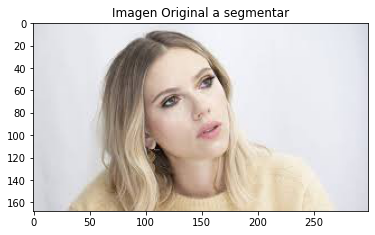

In [5]:
# importamos imagen a tratare
from skimage import io
image = io.imread('scarlet5.jpg') 
plt.title("Imagen Original a segmentar")
plt.imshow(image)

### 1.2 Lectura y despliege de las imagenes Ground Truth generadas con GIMP, para realizar la evaluación de la segmentación usando Indice Jaccard en cada uno de los metodos de segmentación.

(Text(0.5, 1.0, 'Ground Truth - GIMP para K-Means'),
 ([], <a list of 0 Text major ticklabel objects>),
 ([], <a list of 0 Text major ticklabel objects>))

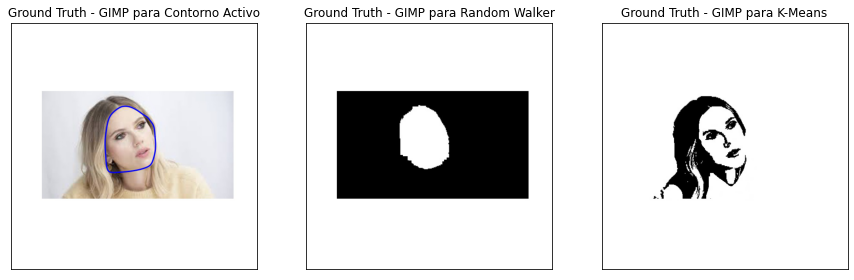

In [6]:
image_contorno_gt = io.imread('image_contorno_gimp.jpg') 
image_random_gt = io.imread('image_random_gimp.jpg') 
image_kmeans_gt = io.imread('image_kmeans_gimp.jpg')
plt.figure(figsize=(15,15))
plt.subplot(2,3,1),plt.imshow(image_contorno_gt , cmap='gray');plt.title('Ground Truth - GIMP para Contorno Activo'), plt.xticks([]), plt.yticks([])
plt.subplot(2,3,2),plt.imshow(image_random_gt);plt.title('Ground Truth - GIMP para Random Walker'), plt.xticks([]), plt.yticks([])
plt.subplot(2,3,3),plt.imshow(image_kmeans_gt);plt.title('Ground Truth - GIMP para K-Means'), plt.xticks([]), plt.yticks([])

### 1.3 El siguiente paso sería convertir la imagen a escala de grises con  Blurring (Image Smoothing) Bilateral Filter, por que he validado que la resolución tanto del Active countour segmentation y Random Walker, funcionan mejor que el rgb2gray.  (Pandey, 2019)

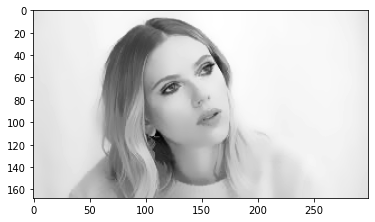

In [7]:
bilateralBlurGray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) # Conversión de la imagen a escala de grises
image_gray = cv2.bilateralFilter(bilateralBlurGray, 13, 15, 15) #Image Blurring (Image Smoothing) Bilateral Filter
plt.imshow(image_gray, cmap='gray');

## Paso 2: Segmentación Supervisada.

La segmentación supervisada, como dice su nombre, es realizar un proceso de segmentación de una región de la imagen, elegida o seleccionada por el usuario, usando distintos metodos. En este caso usaremos dos métodos de segmentación que funcionan con principios completamente diferentes. El metodo Active contour segmentation y el algoritmo Random walker.  (Pandey, 2019)

### 2.1 Metodo de segmentación Active Contour segmentation

El metodo de Segmentación de Contorno Activo (comúnmente llamado Snake) consiste en crear una curva elástica aproximada
que, colocada sobre una imagen, empieza a deformarse a partir de una forma inicial con el fin
de delimitar las regiones de interés en la imagen. Esta deformación se produce mediante la
aplicación de fuerzas internas, intrínsecas al Snake y que controlan la suavidad de la curva, así
como mediante fuerzas externas, procedentes de la imagen bajo tratamiento, que empujan al
Snake hacia las características salientes de la imagen. (Pandey, 2019)

A la función circle_points le entregamos las coordenadas del centro del area del rostro que deseamos segmentar y el diametro de la circunferencia del area a segmentar.  En este caso la resolución es 160 por 250, especificamos 80, 40, con un diametro de 70.

In [8]:
def circle_points(resolution, center, radius):
    """ Generate points defining a circle on an image. """
    radians = np.linspace(0, 2*np.pi, resolution)

    c = center[1] + radius*np.cos(radians)
    r = center[0] + radius*np.sin(radians)
    
    return np.array([c, r]).T

# Exclude last point because a closed path should not have duplicate points
points = circle_points(200, [80, 140], 70)[:-1]

Dibujamos el circulo definido en la imagen, para representar el area a segmentar. 

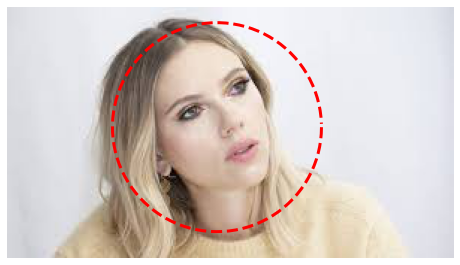

In [9]:
fig, ax = image_show(image)
ax.plot(points[:, 0], points[:, 1], '--r', lw=3)



```
# Tiene formato de código
```

Luego, el algoritmo de la libreria "skimage.segmentation" segmentara la zona del rostro adscrito a la circunferecnia, del resto de la imagen ajustando una curva cerrada a los bordes del rostro.
Podemos modificar los parámetros llamados alfa y beta. Los valores más altos de alfa harán que esta "serpiente" se contraiga más rápido, mientras que la beta hará que la serpiente sea más suave.

Luego de probar varias opciones, he comprovado que incluir una funcion gaussian a la imagen a tratar, tiene mejor resultados.

Finalmente guardamos la imagen para su posterior comparación con el ground truth.

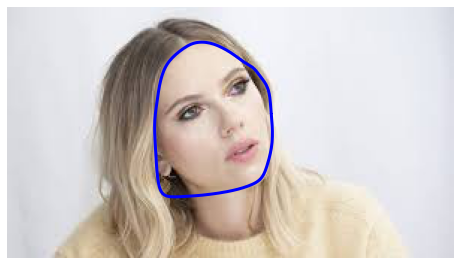

In [10]:
from skimage.filters import gaussian
snake = seg.active_contour(gaussian(image_gray, 2), points,alpha=0.06,beta=0.9)
fig, ax = image_show(image)
#ax.plot(points[:, 0], points[:, 1], '--r', lw=3)
ax.plot(snake[:, 0], snake[:, 1], '-b', lw=3);
fig.savefig('image_contorno_salida.jpg') 


Imagen con el rostro segmentado con el metodo Segmentación de Contorno Activo. 

### 2.2 Metodo de segmentación Random Walker
Este algoritmo segmenta una imagen a partir de un número de píxeles predefinidos con etiquetas denominadas semillas que
indican las distintas regiones a identicar (e.g., objeto y fondo). Estas
semillas se encuentran etiquetadas en los píxeles correspondientes y,
aquellos píxeles sin etiquetas serán marcados por el algoritmo mediante el siguiente planteamiento: "sea un random walker en un píxel sin
etiquetar, ¿cuál es la probabilidad de que llegue primero a cada uno
de los píxeles semillas?. Para ello, se asigna un vector de K − tuplas
a cada píxel, que especique la probabilidad de que un random walker
empiece desde cada píxel sin etiquetar, llegue primero a cada uno de
los K píxeles semillas. Luego, se selecciona de esas de K − tuplas la
semilla más probable para el random walker. (Grady, 2006)

El algoritmo Random Walker espera una imagen de etiqueta como entrada. Entonces tendremos el círculo más grande que abarca toda el area del rostro a segmentar y otro círculo más pequeño cerca de la mitad del area a segmentar.

Utilizaremos las coordenadas con las que generamos el circulo inicial del Active Countour.


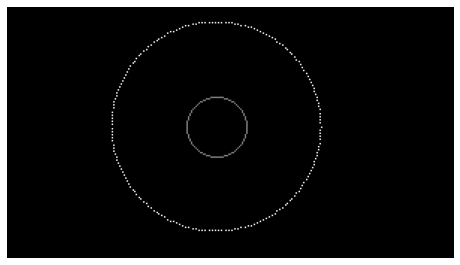

In [11]:
image_labels = np.zeros(image_gray.shape, dtype=np.uint8)

indices = draw.circle_perimeter(80,140,20)#from here
image_labels[indices] = 1
image_labels[points[:, 1].astype(np.int), points[:, 0].astype(np.int)] = 2
image_show(image_labels);

Ahora utilizamos Random Walker, para ver la segmentación de la imagen, en este caso la región del rostro.  Para ir afinando los detalles de los bordes, podemos sintonizar el parámetro beta hasta obtener los resultados deseados. Después de varios intentos, un valor de 3000 funciona razonablemente bien. 

La primera imagen con un alfa de 0.3 segmenta perfectamente el rostro deseado, pero la segunda imagen generada con alpha 1, nos permite obtener una segmentación  (blanco/nego), que nos servira para comparar con el ground truth generado con GIMP. 

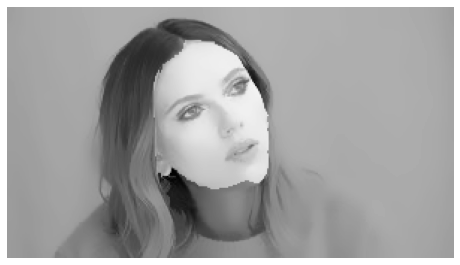

In [12]:
image_segmented = seg.random_walker(image_gray, image_labels, beta = 3000)
# Check our results
fig, ax = image_show(image_gray)
ax.imshow(image_segmented == 1, alpha=0.3, cmap='gray');

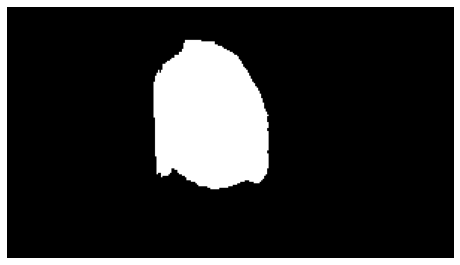

In [13]:
fig, ax = image_show(image_gray)
ax.imshow(image_segmented == 1, alpha=1, cmap='gray');
fig.savefig('image_random_salida.jpg') 

Imagen segmentada utilizando Random Walker

### 2.3 Validación segmentación Random Walker con Ground Truth generado con GIMP, usando Indice Jaccard 

El índice de Jaccard o coeficiente de similitud de Jaccard, definido como el tamaño de la intersección dividido por el tamaño de la unión de dos conjuntos de etiquetas, se usa para comparar el conjunto de etiquetas predichas para una muestra con el conjunto de etiquetas correspondiente en y_true (Edeza, s.f.) 

(Text(0.5, 1.0, 'Imagen Ground Truth generada por GIMP'),
 ([], <a list of 0 Text major ticklabel objects>),
 ([], <a list of 0 Text major ticklabel objects>))

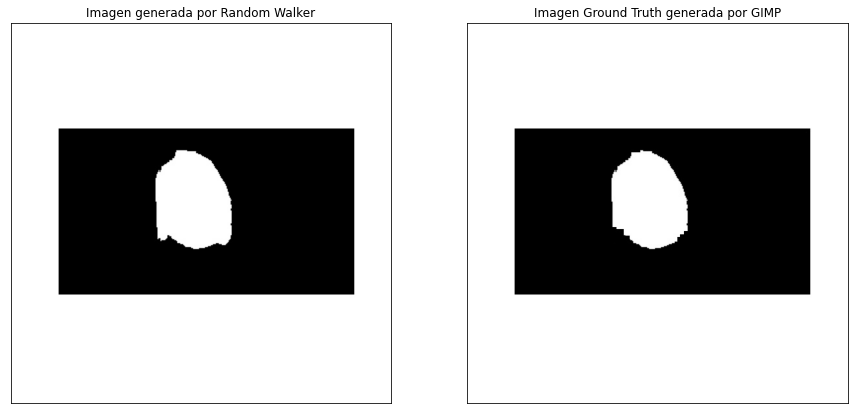

In [14]:
image_salida = io.imread('image_random_salida.jpg') 
plt.figure(figsize=(15,15))
plt.subplot(1,2,1),plt.imshow(image_salida);plt.title('Imagen generada por Random Walker'), plt.xticks([]), plt.yticks([])
plt.subplot(1,2,2),plt.imshow(image_random_gt);plt.title('Imagen Ground Truth generada por GIMP'), plt.xticks([]), plt.yticks([])

### 2.4 Calculamos indice Jaccard leyendo ambas imagenes de disco.

In [15]:
import numpy as np
from sklearn.metrics import jaccard_similarity_score
from skimage.color import rgb2gray
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import ndimage

image1 = plt.imread('image_random_salida.jpg')
image2 = plt.imread('image_random_gimp.jpg')

image1=np.array(image1).ravel()
image2=np.array(image2).ravel()

print(image1.shape, image2.shape)

(995328,) (995328,)


### 2.5 Mostramos el resultado de la evaluación. Siendo 1 un 100% de similitud en la imagen. En el caso del ejemplo observamos un 98% de similitud

In [16]:
iou = jaccard_similarity_score(image1, image2)
print(iou)

0.9880310812114198


## Paso 3 Segmentación No Supervisada Clustering (K-Means)

La segmentación no supervisada no requiere conocimientos previos de la imagen y no es necesario la participación de un persona que parametrice el area de la imagen a tratar. La segmentación no supervisada y en este caso el algoritmo K-Means puede dividir la imagen en varias subregiones, por lo que la imagen en lugar de tener millones de píxeles, solo tendra las regiones que nosotros definamos en el parametro del cluster. (Edeza, s.f.) (scikit-image.org, s.f.)


In [17]:
# leemos la imagen a tratar 
pic = plt.imread('scarlet5.jpg')/255  # dividimos la imagen por 255 para dejar pixeles solo entre 0 y 1

In [18]:
pic_n = pic.reshape(pic.shape[0]*pic.shape[1], pic.shape[2])
pic_n.shape

(50232, 3)

 Importamos las librerias necesarias para ejecutar el algoritmo KMeans

In [19]:
from sklearn.cluster import KMeans

Generamos el cluster de la imagen, en este caso con 2 cluster para representar mejor la imagen en 2 escalas de grises

In [20]:
kmeans = KMeans(n_clusters=2, random_state=0).fit(pic_n)
pic2show = kmeans.cluster_centers_[kmeans.labels_]

Generamos la nueva imagen

In [21]:
cluster_pic = pic2show.reshape(pic.shape[0], pic.shape[1], pic.shape[2])
cluster_pic = rgb2gray(cluster_pic)

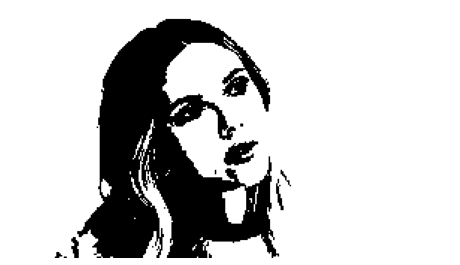

In [22]:
fig, ax = image_show(cluster_pic)
ax.imshow(cluster_pic, cmap='gray');
fig.savefig('image_kmeans_salida.jpg') 

Imagen segmentada utilizando K-Menas

### 3.2 Validación segmentación KMeans con Ground Truth generado con GIMP, usando Indice Jaccard

El índice de Jaccard o coeficiente de similitud de Jaccard, definido como el tamaño de la intersección dividido por el tamaño de la unión de dos conjuntos de etiquetas, se usa para comparar el conjunto de etiquetas predichas para una muestra con el conjunto de etiquetas correspondiente en y_true (Edeza, s.f.) 

(Text(0.5, 1.0, 'Imagen Ground Truth generada por GIMP'),
 ([], <a list of 0 Text major ticklabel objects>),
 ([], <a list of 0 Text major ticklabel objects>))

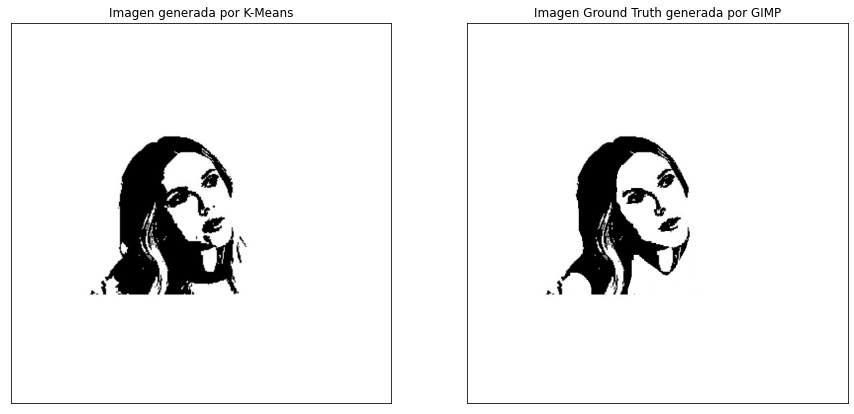

In [23]:
image_salida = io.imread('image_kmeans_salida.jpg') 
plt.figure(figsize=(15,15))
plt.subplot(1,2,1),plt.imshow(image_salida, cmap='gray');plt.title('Imagen generada por K-Means'), plt.xticks([]), plt.yticks([])
plt.subplot(1,2,2),plt.imshow(image_kmeans_gt, cmap='gray');plt.title('Imagen Ground Truth generada por GIMP'), plt.xticks([]), plt.yticks([])

### 3.3 Calculamos indice Jaccard leyendo ambas imagenes de disco.

Leemos las imagenes desde el fichero, por que al utilizar la imagenes generadas en sus variables en memoria, presentaba fallos el algoritmo.

In [24]:
import numpy as np
from sklearn.metrics import jaccard_similarity_score
from skimage.color import rgb2gray
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import ndimage

image1 = plt.imread('image_kmeans_salida.jpg')
image2 = plt.imread('image_kmeans_gimp.jpg')

image1=np.array(image1).ravel()
image2=np.array(image2).ravel()

print(image1.shape, image2.shape)

(995328,) (995328,)


### 3.4 Mostramos el resultado de la evaluación. Siendo 1 un 100% de similitud en la imagen. En el caso del ejemplo observamos un 94% de similitud

In [25]:
iou = jaccard_similarity_score(image1, image2)
print(iou)

0.9483868634259259


## Comentarios y conclusión.

las imagenes Ground Truth fueron generadas a partir de la imagen original utilizando las herramientas del producto GIMP usadas en clases para las demostraciones de distintos tratamientos de imágenes.

Es importante destacar como se ha comentado, que para la validación de segmentación, que compara las imágenes Ground Truth con las generadas por los algoritmos, fue necesario que en cada generación de la imagen segmentada, esta fuera guardada a disco, para posteriormente leerla desde el la rutina de validación Jaccard, de lo contrario la función presentaba fallos, que no tenía solución, salvo lo ya mencionado. Por eso lo aclaro por si resukta algo extraño, que lea las imagenes antes de tratarlas por el Jaccard.

Debo reconocer que al principio la practica me resulto compleja de entender, pero una vez leída la unidades de clase donde se trataban estos temas, vi la real necesidad de la solución planteada.

Como conclusión, me ha parecido una actividad muy interesante y realmente he aprendido y comprendido su utilidad. 

## Bibliografia:
    

Edeza, T. (s.f.). Image Processing for Python — Adjusting to the Ground Truth. Obtenido de https://towardsdatascience.com/image-processing-for-python-adjusting-to-the-ground-truth-d0275e4f253e

Pandey, P. (02 de 2019). towardsdatascience.com. Obtenido de https://towardsdatascience.com/image-segmentation-using-pythons-scikit-image-module-533a61ecc980

scikit-image.org. (s.f.). Image processing in Python. Obtenido de https://scikit-image.org/docs/dev/api/skimage.segmentation.html

Grady, L. Random walks for image segmentation. IEEE Transactions
on Pattern Analysis and Machine Intelligence, vol. 28(11), páginas 1768
1783, 2006.

 (Wechsler y Kidode, 1979; Tetali, 1991;
Grady, 2006)


